# Modélisation – Credit Scoring

L’objectif de cette étape est de comparer plusieurs algorithmes de classification
afin de sélectionner le modèle le plus adapté au problème de scoring crédit.

Le dataset présente :
- un déséquilibre de la variable cible
- un fort enjeu métier sur les erreurs de type faux positifs


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import matplotlib.pyplot as plt


In [56]:
import pandas as pd

# Charger les données préparées
data_fe = pd.read_csv("../data/data_fe.csv")

# Séparer variables explicatives et cible
X = data_fe.drop("TARGET", axis=1)
y = data_fe["TARGET"]


In [57]:
# Séparation des données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% des données pour le test
    random_state=42,    # reproductibilité
    stratify=y          # conserver la proportion défaut / non défaut
)

print("Jeu d'entraînement :", X_train.shape)
print("Jeu de test        :", X_test.shape)

Jeu d'entraînement : (246008, 229)
Jeu de test        : (61503, 229)


**Définition des pipelines**

In [77]:


models = {
    "Logistic Regression": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(max_iter=1000))
    ]),
    
    "Random Forest": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("classifier", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    
    "Gradient Boosting": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("classifier", HistGradientBoostingClassifier(random_state=42))
    ])
}




In [67]:
X_train.dtypes[X_train.dtypes == "object"]


Series([], dtype: object)

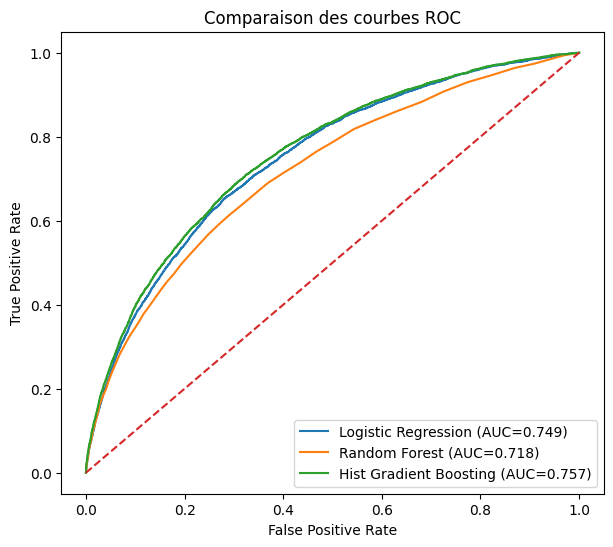

In [69]:
# Entraînement & évaluation
# On utilise AUC ROC
results = []

plt.figure(figsize=(7,6))

for name, model in models.items():
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # AUC
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "AUC": auc
    })
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

# Courbe aléatoire
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparaison des courbes ROC")
plt.legend()
plt.show()


In [70]:
# Comparaison des résultats
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
results_df


,Model,AUC
2,Hist Gradient Boosting,0.757407
0,Logistic Regression,0.748534
1,Random Forest,0.718373


In [78]:
# Analyse détaillée du meilleur modèle
best_model = models["Gradient Boosting"]
best_model.fit(X_train, y_train)

# Prédictions binaires avec seuil 0.5
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.70      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.81      0.51      0.50     61503
weighted avg       0.90      0.92      0.88     61503



In [79]:
confusion_matrix(y_test, y_pred)


array([[56499,    39],
       [ 4876,    89]])

## Choix du modèle final

Parmi les modèles testés :
- la régression logistique offre une bonne interprétabilité mais des performances limitées
- le random forest améliore la performance mais reste complexe à expliquer
- le gradient boosting obtient la meilleure AUC et un bon compromis biais / variance

Le **Gradient Boosting** est donc sélectionné comme modèle final,
sous réserve d’un travail complémentaire sur l’interprétabilité locale.


In [81]:
# Sauvergarde du modèle

import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/credit_scoring_model.pkl")


['models/credit_scoring_model.pkl']